## **Semi Supervised Learning with Noisy Student and Pseudo Labels** 

**What is Semi Supervised Learning?**

Semi-Supervised Learning is an approach to Machine Learning that combines a small amount of labeled data with a large amount of unlabeled data during training.

Semi Supervised learning falls between unsupervised learning(with no labeled training data) and supervised learning(with only labeled training data.

In order to make any use of unlabeled data, some relationship to the underlying distribution of data must exist. Semi-supervised learning algorithms make use of at least one of the following assumptions:[2]

**Continuity assumption**
Points that are close to each other are more likely to share a label. This is also generally assumed in supervised learning and yields a preference for geometrically simple decision boundaries. In the case of semi-supervised learning, the smoothness assumption additionally yields a preference for decision boundaries in low-density regions, so few points are close to each other but in different classes.

**Cluster assumption** 
The data tend to form discrete clusters, and points in the same cluster are more likely to share a label (although data that shares a label may spread across multiple clusters). This is a special case of the smoothness assumption and gives rise to feature learning with clustering algorithms.

**Manifold assumption**

The data lie approximately on a manifold of much lower dimension than the input space. In this case learning the manifold using both the labeled and unlabeled data can avoid the curse of dimensionality. Then learning can proceed using distances and densities defined on the manifold.

The manifold assumption is practical when high-dimensional data are generated by some process that may be hard to model directly, but which has only a few degrees of freedom. For instance, human voice is controlled by a few vocal folds,[3] and images of various facial expressions are controlled by a few muscles. In these cases distances and smoothness in the natural space of the generating problem, is superior to considering the space of all possible acoustic waves or images, respectively.





### **Abstract**

We aim to test the self-training method on a structured dataset and test to see if there is an increase in performance on the Machine Learning models as observed on the DL Models. We first train a model on the labelled data and use it as a teacher to generate pseudo labels on unseen Test data. We then train a larger Model as a student model on the combination of labeled and pseudo labeled data. We iterate this process by putting back the student as the teacher. During the generation of the pseudo labels, the teacher is not noised so that the pseudo labels are as acuurate as possible. However, during the learning of the student, we inject noise so the student genralizes better than the teacher.

### **Algorithm**

Semi supervised learning uses both labelled data and unlabelled data for learning.
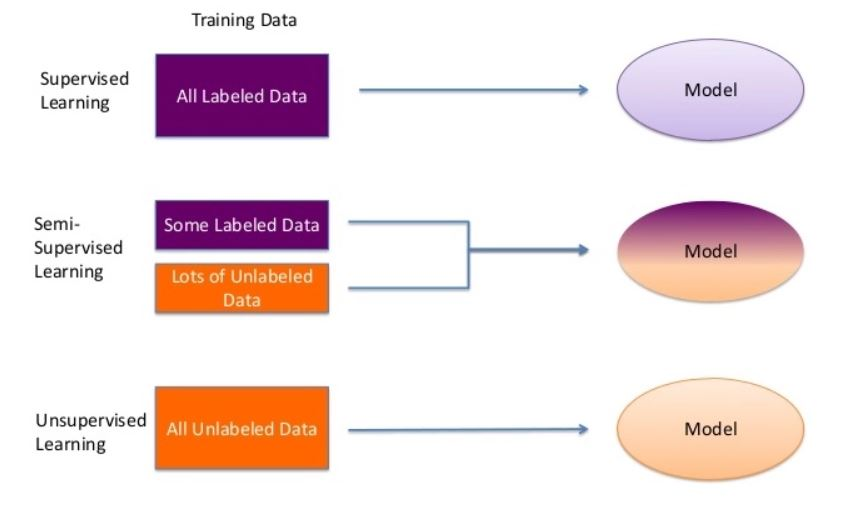


**Introduction To Pseudo Labelling**

In this technique instead of manually labeling the unlabeled data, we give approximate labels on the basis of the labeled data. The steps to do this are shown in the image below.

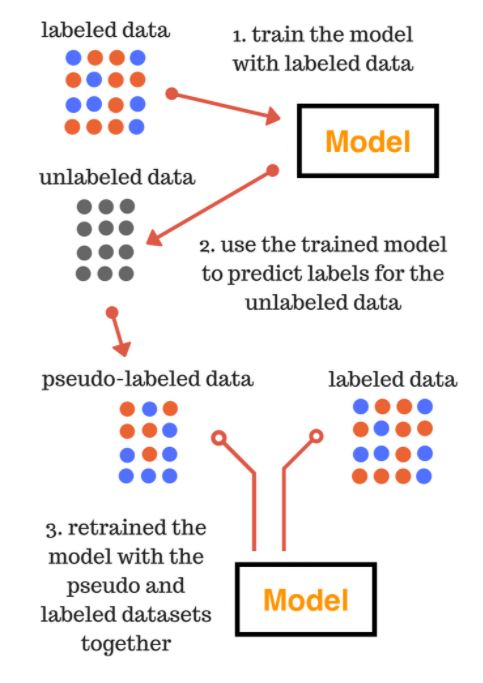

## **Implementation of SSL**

We test and implement Semi Supervised Learning on a Structured dataset to see how it performs on an ML Model. We have taken the Classic Titanic Dataset
Kaggle Link - https://www.kaggle.com/c/titanic

**Importing the Libraries**

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt  

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from matplotlib import rcParams
from sklearn import metrics
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from xgboost import XGBClassifier
from google.colab import files


#Visualization 
import seaborn as sns

%matplotlib inline

**Reading the Data In**

In [2]:
drive.mount('/content/drive')
df_train = pd.read_csv('drive/My Drive/Colab Notebooks/Titanic_ML_From_Disaster/train.csv') 
df_test = pd.read_csv('drive/My Drive/Colab Notebooks/Titanic_ML_From_Disaster/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Preprocessing the Data**

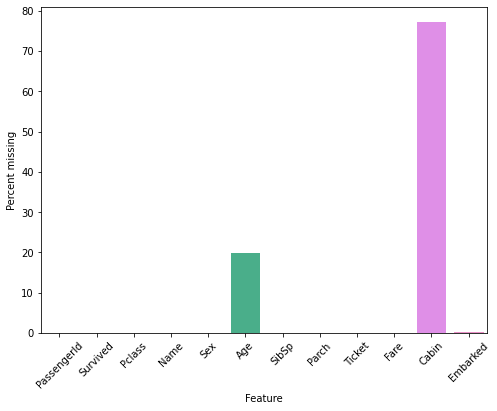

In [6]:
#Checking the dataset for Null values
null_vals = df_train.isnull().sum()/len(df_train)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [7]:
#As Cabin has a lot of null values, we drop the feature column "Cabin"
df_train1 = df_train.drop("Cabin", axis = 1)
print(df_train.shape)

(891, 12)


In [8]:
df_train1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [9]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [10]:
#You can see that several of the columns or features are "object" type. These need to be changed to category before we can convert those to mappings and numbers
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [11]:
df_train2 = str_to_cat(df_train1)


In [12]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Embarked     889 non-null    category
dtypes: category(4), float64(2), int64(5)
memory usage: 126.5 KB


In [13]:
#Check the cateogry mapping for Embarked and Sex column.
print(df_train2.Embarked.cat.categories)
print(df_train2.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [14]:
#Define impute functions. Impute categorical NaNs with -1, where we add 1 to make it 0. 
#For each continuous variables, we impute missing values with median values of thatcolumn, 
#and for every variablewhere any rows were imputed, add a separate 'imputed or not' column

def df_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [15]:
df_train3,table = mydf_preprocessor(df_train2,null_table = None)

In [16]:
df_train3.head(3)
df_train4 = df_train3.drop("Age_na", axis = 1)
df_train4.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,109,2,22.0,1,0,524,7.2500,3
1,2,1,1,191,1,38.0,1,0,597,71.2833,1
2,3,1,3,354,1,26.0,0,0,670,7.9250,3
3,4,1,1,273,1,35.0,1,0,50,53.1000,3
4,5,0,3,16,2,35.0,0,0,473,8.0500,3


In [17]:
table

{'Age': 28.0}

In [18]:

'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

y_train = df_train4["Survived"]
x_train = df_train4.drop(["Survived"],axis = 1)

print(x_train.shape,y_train.shape)

(891, 10) (891,)


In [19]:
#Splitting into train and Validation set

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 1)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(668, 10) (668,) (223, 10) (223,)


In [20]:
x_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
35,36,1,373,2,42.0,1,0,44,52.0000,3
46,47,3,474,2,28.0,1,0,463,15.5000,2
453,454,1,291,2,49.0,1,0,85,89.1042,1
291,292,1,91,1,19.0,1,0,65,91.0792,1
748,749,1,512,2,19.0,1,0,36,53.1000,3


In [21]:
x_val.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
862,863,1,798,1,48.0,0,0,89,25.9292,3
223,224,3,582,2,28.0,0,0,376,7.8958,3
84,85,2,387,1,17.0,0,0,638,10.5000,3
680,681,3,656,1,28.0,0,0,282,8.1375,2
535,536,2,342,1,7.0,0,2,572,26.2500,3


Pre Processing Test Set

In [22]:
df_test.shape

(418, 11)

In [23]:
df_test1 = df_test.drop("Cabin", axis = 1)
print(df_test1.shape)
df_test1.head()

(418, 10)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [24]:
df_test2 = str_to_cat(df_test1)
df_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [25]:
df_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [26]:
df_test3, table1 = mydf_preprocessor(df_test2, null_table = table)
print(df_test3.shape)
df_test3.head()

(418, 12)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,892,3,207,2,34.5,0,0,153,7.8292,2,False,False
1,893,3,404,1,47.0,1,0,222,7.0000,3,False,False
2,894,2,270,2,62.0,0,0,74,9.6875,2,False,False
3,895,3,409,2,27.0,0,0,148,8.6625,3,False,False
4,896,3,179,1,22.0,1,1,139,12.2875,3,False,False


In [27]:
table1

{'Age': 28.0, 'Fare': 14.4542}

In [28]:
df_test3.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,892,3,207,2,34.5,0,0,153,7.8292,2,False,False
1,893,3,404,1,47.0,1,0,222,7.0000,3,False,False
2,894,2,270,2,62.0,0,0,74,9.6875,2,False,False
3,895,3,409,2,27.0,0,0,148,8.6625,3,False,False
4,896,3,179,1,22.0,1,1,139,12.2875,3,False,False


In [29]:
x_test = df_test3.drop(["Age_na","Fare_na"], axis = 1)

In [30]:
print(x_test.shape)
x_test.head(3)

(418, 10)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,207,2,34.5,0,0,153,7.8292,2
1,893,3,404,1,47.0,1,0,222,7.0000,3
2,894,2,270,2,62.0,0,0,74,9.6875,2


In [31]:
TestdataID = pd.DataFrame(x_test['PassengerId'], columns = ['PassengerId'])

## **Testing with ML Models**

**Testing with Random Forests**

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

model_rf = RandomForestClassifier(n_estimators = 100, max_depth=7)
model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
#Generating Pseudo labels from the Test Set
pseudo_rf = model_rf.predict(x_test)
print(pseudo_rf)

[0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [36]:
Accuracyrf = model_rf.score(x_val, y_val)
print("Accuracy of the Random Forest model on the Validation Set: ", Accuracyrf*100, "%")


Accuracy of the Random Forest model on the Validation Set:  77.13004484304933 %


In [44]:

model_rf_pred = model_rf.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (model_rf_pred>=0.5).astype(int),
    }
)
submission.to_csv(f"rf_submission_final.csv", index = False)

In [45]:
files.download("rf_submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
#Concatenating Generated Pseudo Labels and Training data
X_rf = np.vstack((x_train, x_test))
Y_rf = np.concatenate((y_train, pseudo_rf), axis = 0)

In [42]:
#Training Student Model with Labeled and Unlabeled Data
pseudo_model_rf = RandomForestClassifier(n_estimators = 100, max_depth=7)
pseudo_model_rf.fit(X_rf, Y_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
Accuracyrf_pseudo = pseudo_model_rf.score(x_val, y_val)
print("Accuracy of the Pseudo model: ", Accuracyrf_pseudo*100, "%")

Accuracy of the Pseudo model:  77.57847533632287 %


In [46]:
pseudo_rf_pred1 = pseudo_model_rf.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (pseudo_rf_pred1>=0.5).astype(int),
    }
)
submission.to_csv(f"rf_pseudo_final.csv", index = False)

In [47]:

files.download("rf_pseudo_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Observation**

There is an increase in the accuracy for the pseudo model on the Validation Set by 0.5% by inducing noise in the data

**Testing with Gradient Boosting**

In [56]:
#LGradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier(learning_rate=0.5, max_depth=7, n_estimators=100, random_state=42)
model_gb.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [57]:
#Generating Pseudo Labels from Teacher Model
pseudo_gb = model_gb.predict(x_test)
print(pseudo_gb)

[0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0
 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0
 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0
 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 0 0 1]


In [58]:
Accuracygb = model_gb.score(x_val,y_val)
print("Accuracy of the model1 model: ", Accuracygb*100, "%")

Accuracy of the model1 model:  76.68161434977578 %


In [59]:
model_gb_pred1 = model_gb.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (model_gb_pred1>=0.5).astype(int),
    }
)
submission.to_csv(f"gb_submission.csv", index = False)

In [61]:
files.download("gb_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
#Concatenating Generated Pseudo labels with Training Data to induce noise
X_gb = np.vstack((x_train, x_test))
Y_gb = np.concatenate((y_train, pseudo_gb), axis = 0)

In [63]:
#Training Model with labeled and Unlabeled data
pseudo_gb_model = GradientBoostingClassifier(learning_rate=0.5, max_depth=7, n_estimators=100, random_state=42)
pseudo_gb_model.fit(X_gb, Y_gb)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [64]:
Accuracygb_pseudo = pseudo_gb_model.score(x_val,y_val)
print("Accuracy of the model1 model: ", Accuracygb_pseudo*100, "%")

Accuracy of the model1 model:  78.47533632286996 %


In [65]:
model_gb_pseudo_pred2 = pseudo_gb_model.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (model_gb_pseudo_pred2>=0.5).astype(int),
    }
)
submission.to_csv(f"gb_pseudo_submission.csv", index = False)

In [66]:
files.download("gb_pseudo_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Observation**

There is an almost 2% increase in the accuracy when noise is introduced into the training data on the validation set

**Testing with Decision Trees**

In [79]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [80]:
pseudo_dt = model_dt.predict(x_test)
print(pseudo_dt)

[0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0
 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0
 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0
 0 0 1 0 1 0 0 1 0 0 0]


In [81]:
Accuracydt = model_dt.score(x_val,y_val)
print("Accuracy of the model1 model: ", Accuracydt*100, "%")

Accuracy of the model1 model:  74.43946188340807 %


In [70]:
#Concatenating Generated Pseudo Labels with Training Data
X_dt = np.vstack((x_train, x_test))
Y_dt = np.concatenate((y_train, pseudo_dt), axis = 0)

In [71]:
model_dt_pred1 = model_dt.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (model_dt_pred1>=0.5).astype(int),
    }
)
submission.to_csv(f"dt_submission.csv", index = False)

In [72]:
files.download("dt_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
#Training The Model with Labelled and Noisy Data
pseudo_dt_model = DecisionTreeClassifier()
pseudo_dt_model.fit(X_dt,Y_dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [83]:
Accuracydt_pseudo = pseudo_dt_model.score(x_val,y_val)
print("Accuracy of the model1 model: ", Accuracydt_pseudo*100, "%")

Accuracy of the model1 model:  74.88789237668162 %


In [85]:
pseudo_dt_pred = pseudo_dt_model.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (pseudo_dt_pred>=0.5).astype(int),
    }
)
submission.to_csv(f"dt_pseudo_submission.csv", index = False)

In [86]:
files.download("dt_pseudo_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Observation**

There seems to be a small increase in the accuracy of 0.4% when training data is noised on the Decision Tree Classifier Model

**Testing with Logistic Regression**

In [89]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(C=2.80, class_weight = None, dual=False, fit_intercept = True, intercept_scaling = 1, max_iter = 100
                             , multi_class='auto', n_jobs = None, penalty='l2', random_state=None, solver='newton-cg', tol=0.0001, verbose = 0, warm_start=False)

In [90]:
#Training Teacher Model and Generating Pseudo labels
model_lr.fit(x_train, y_train)
pseudo_labels_lr = model_lr.predict(x_test)
print(pseudo_labels_lr)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1
 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0
 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0
 0 1 1 1 1 1 0 1 0 0 0]


In [91]:
Accuracylr = model_lr.score(x_train, y_train)
print("Accuracy of the model1 model: ", Accuracylr*100, "%")

Accuracy of the model1 model:  80.53892215568862 %


In [92]:
model_lr_pred1 = model_lr.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (model_lr_pred1>=0.5).astype(int),
    }
)
submission.to_csv(f"lr_submission.csv", index = False)

In [93]:
files.download("lr_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
X_lr = np.vstack((x_train, x_test))
Y_lr = np.concatenate((y_train, pseudo_labels_lr), axis = 0)

In [95]:
pseudo_model_lr =  LogisticRegression(C=2.80, class_weight = None, dual=False, fit_intercept = True, intercept_scaling = 1, max_iter = 100
                             , multi_class='auto', n_jobs = None, penalty='l2', random_state=None, solver='newton-cg', tol=0.0001, verbose = 0, warm_start=False)
pseudo_model_lr.fit(X_lr, Y_lr)

LogisticRegression(C=2.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
Accuracylr_pseudo = pseudo_model_lr.score(X_lr, Y_lr)
print("Accuracy of the model1 model: ", Accuracylr_pseudo*100, "%")

Accuracy of the model1 model:  87.38489871086557 %


In [97]:
model_lr_pred2 = pseudo_model_lr.predict(x_test)
submission = pd.DataFrame(
    {
        'PassengerId': x_test["PassengerId"],
         'Survived': (model_lr_pred2>=0.5).astype(int),
    }
)
submission.to_csv(f"lr_pseudo_submission.csv", index = False)

In [98]:
files.download("lr_pseudo_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Observation**

Logistic Regression seems to be the most responsive to noisy data with an accuracy increase of almost 7% as observed on the validation set

### **Conclusion**

After testing the Noisy Student and Pseudo Labelling approach on Conventional Machine Learning Models, it is observed that there is a small increase in the Model performance when the models are trained with Data that is noised with Pseudo Labels

### **References**

1. https://www.groundai.com/project/self-training-with-noisy-student-improves-imagenet-classification/1
2. Wikipedia - https://en.wikipedia.org/wiki/Semi-supervised_learning
3. Analytics Vidhya - https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/
4. Machine Learning Mastery
5. Kaggle Kernels - https://www.kaggle.com/farisai/titanic-using-the-pseudo-labeling-method
6. Kaggle Kernels - https://www.kaggle.com/datafan07/titanic-eda-and-several-modelling-approaches

### **LICENSE**

Copyright <2020> Keshav K L

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.